# XD on magnitude and shape distributions

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import corner as cn
import desitarget.cuts

from astropy.io import fits
from astropy.table import Table, join
from sklearn.mixture import GaussianMixture
from desitarget.targetmask import desi_mask, bgs_mask

from astroML.density_estimation import XDGMM

from scipy.stats import chisquare

import time
import pickle

In [3]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covariances_, name='covars'))
        hdus.writeto(filename, overwrite=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [4]:
def keep(data):
    
    # Select parameters we want to model
    # Don't include W3, W4 --> It's not used in targeting and too shallow to be useful
    
    params = np.empty(len(data), dtype=[('g', 'f4'), ('r', 'f4'), ('z', 'f4'),
                                          ('w1', 'f4'), ('w2', 'f4'), ('fracdev', 'f4'), ('exp_r', 'f4'), ('exp_e1', 'f4'),
                                          ('exp_e2', 'f4'), ('dev_r', 'f4'), ('dev_e1', 'f4'),
                                          ('dev_e2', 'f4')])
    errs = np.copy(params)
    
    # Flux params
    params['g'] = data['decam_flux'][:,1]
    params['r'] = data['decam_flux'][:,2]
    params['z'] = data['decam_flux'][:,4]
    params['w1'] = data['wise_flux'][:,0]
    params['w2'] = data['wise_flux'][:,1]
    
    # Shape params
    params['fracdev'] = data['fracDev']
    params['exp_r'] = data['shapeExp_r']
    params['exp_e1'] = data['shapeExp_e1']
    params['exp_e2'] = data['shapeExp_e2']
    params['dev_r'] = data['shapeDev_r']
    params['dev_e1'] = data['shapeDev_e1']
    params['dev_e2'] = data['shapeDev_e2']
    
    
    # Errors
    errs['g'] = np.sqrt(1 / data['decam_flux_ivar'][:,1])
    errs['r'] = np.sqrt(1 / data['decam_flux_ivar'][:,2])
    errs['z'] = np.sqrt(1 / data['decam_flux_ivar'][:,4])
    errs['w1'] = np.sqrt(1 / data['wise_flux_ivar'][:,0])
    errs['w2'] = np.sqrt(1 / data['wise_flux_ivar'][:,1])
    errs['fracdev'] = np.sqrt(1 / data['fracDev_ivar'])
    errs['exp_r'] = np.sqrt(1 / data['shapeExp_r_ivar'])
    errs['exp_e1'] = np.sqrt(1 / data['shapeExp_e1_ivar'])
    errs['exp_e2'] = np.sqrt(1 / data['shapeExp_e2_ivar'])
    errs['dev_r'] = np.sqrt(1 / data['shapeDev_r_ivar'])
    errs['dev_e1'] = np.sqrt(1 / data['shapeDev_e1_ivar'])
    errs['dev_e2'] = np.sqrt(1 / data['shapeDev_e2_ivar'])
    
    return(params, errs)

def get_bic(data, components_range):
    
    # Generate bic for each component in the range given
        
    bic = []
    for comp in components_range:
        model = GaussianMixture(n_components=comp, covariance_type='full')
        model.fit(data)
        bic.append(model.bic(data))
        #print('Component: {:d}'.format(comp))
    return bic

def plot_bic(bic, components_range, save=None):
    
    # Plot bic for each component
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(components_range, np.asarray(np.asarray(bic)/100), marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion/100')
    plt.title('Optimal number of components = {:d}'.format(np.argmin(bic)))
    if save:
        plt.savefig(save)
    plt.show()  


def make_gmm_model(X_data, components_range, model_filename=None, seed=123, bic_plot=False, save=None):
    
    # Create Gaussian Mixture Model based on optimal bic value
    
    # List of bic values for given range of components
    bic = get_bic(X_data, components_range)
    #option to plot bic values
    if bic_plot:
        plot_bic(bic, components_range, save)
    # Index of lowest bic value gives the optimal number of components
    n_comp = np.argmin(bic)
    gen = np.random.RandomState(seed)
    model = GaussianMixture(n_components=n_comp, covariance_type="full", random_state=gen).fit(X_data)
    if model_filename:
        GaussianMixtureModel.save(model, model_filename)
        print('Saved GMM as {:s}.'.format(model_filename))
    else:
        return model

In [5]:
def data_cross_split(params):
    
    # Splits data into training and validation sets
    
    tot = len(params)
    half = np.floor(tot/2.).astype(int)
    data = params[:half]
    cross = params[half:tot]
    return data, cross

def sample(target_type, n_targets, random_state=None):
    
    # Sample from saved Gaussian Mixture Models
    
    if target_type == 'LRG':
        model = GaussianMixtureModel.load('data/v2/lrg_gmm.fits')
    elif target_type == 'ELG':
        model = GaussianMixtureModel.load('data/v2/elg_gmm.fits')
    elif target_type == 'QSO':
        model = GaussianMixtureModel.load('data/v2/qso_gmm.fits')
    elif target_type == 'BGS':
        model = GaussianMixtureModel.load('data/v2/bgs_gmm.fits')
    return  model.sample(n_targets, random_state)

#### Import selection dr2 targets that have passed selection cuts

In [6]:
lrg = Table.read('data/v2/lrg_cuts.fits', format='fits')
elg = Table.read('data/v2/elg_cuts.fits', format='fits')
qso = Table.read('data/v2/qso_cuts.fits', format='fits')
bgs = Table.read('data/v2/bgs_cuts.fits', format='fits')

print(len(lrg), len(elg), len(bgs), len(qso))

704249 379835 242640 64986


#### Load parameters and their errors for each target type

In [12]:
lrg_data, lrg_sig = keep(lrg)
elg_data, elg_sig = keep(elg)
bgs_data, bgs_sig = keep(bgs)
qso_data, qso_sig = keep(qso)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:1163: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


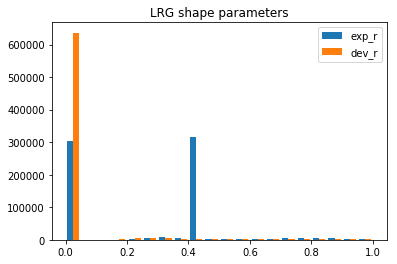

In [13]:
plt.hist((lrg_data['exp_r'], lrg_data['dev_r']), bins=20, range=(0,1), 
         label=('exp_r', 'dev_r'))
plt.title('LRG shape parameters')
plt.legend()
plt.show()

#### Divide data into three categories: those with fracDev < eps, fracDev > 1-eps, eps < fracDev < 1-eps
```Make separate models for flux and shape parameters for each of these categories (don't include fracDev)```

```Do analysis for: exp, dev, comp, psf separately
Are exp e1, e2, r  with the psf deconvolved? Make sure we are simulating psf-deconvolved galaxies (they are)```


In [14]:
def get_fracdev_cuts(data, sig, profile, eps):
    
    if profile == 'exp':
        select = (data['fracdev'] < eps) & (data['exp_r'] != 0) & (data['exp_e1'] != 0) & (data['exp_e2'] != 0) & (sig['exp_r'] != 0) & (sig['exp_e1'] != 0) & (sig['exp_e2'] != 0)
        names = ['g', 'r', 'z', 'w1', 'w2', 'exp_r', 'exp_e1', 'exp_e2']


    if profile == 'dev':
        select = (data['fracdev'] > (1-eps)) & (data['dev_r'] != 0) & (data['dev_e1'] != 0) & (data['dev_e2'] != 0) & (sig['dev_r'] != 0) & (sig['dev_e1'] != 0) & (sig['dev_e2'] != 0)
        names = ['g', 'r', 'z', 'w1', 'w2', 'dev_r', 'dev_e1', 'dev_e2']
    
    if profile == 'mix':
        select = (data['fracdev'] >= eps) & (data['fracdev'] <= (1-eps)) & (data['exp_r'] != 0) & (data['exp_e1'] != 0) & (data['exp_e2'] != 0) & (data['dev_r'] != 0) & (data['dev_e1'] != 0) & (data['dev_e2'] != 0) & (sig['exp_r'] != 0) & (sig['exp_e1'] != 0) & (sig['exp_e2'] != 0) & (sig['dev_r'] != 0) & (sig['dev_e1'] != 0) & (sig['dev_e2'] != 0)
        names = ['g', 'r', 'z', 'w1', 'w2', 'exp_r', 'exp_e1', 'exp_e2', 'dev_r', 'dev_e1', 'dev_e2']
    
    X = np.empty((len(names), np.count_nonzero(select)), dtype=float)
    err = np.copy(X)


    for i, name in enumerate(names):
        X[i] = data[name][select]
        err[i] = sig[name][select]

    return(X, err)


def XD_format(X, err):
    
    X = X.T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    # Assume errors in flux are independent of each other
    # When incorporating shape parameters, do these correlate with flux values? --> yes; the assumption above is not correct
   
    if len(err) == 8:
        Xerr[:, diag, diag] = np.vstack([err[0], err[1], err[2], err[3], err[4], err[5], err[6], err[7]]).T 

    else:
        Xerr[:, diag, diag] = np.vstack([err[0], err[1], err[2], err[3], err[4], err[5], err[6], err[7], err[8], err[9], err[10]]).T 
    
    return(X, Xerr)

def compute_XD_results(X, Xerr, n_components=30, n_iter=100):
    clf = XDGMM(n_components, n_iter=n_iter)
    clf.fit(X, Xerr)
    return clf

In [15]:
def add_xd_errs(xd, band_err):
    new_xd = np.empty(len(xd), dtype=float)
    for i in range(len(xd)):
        index = randint(0,len(band_err)-1)
        std = band_err[index]
        err = np.random.normal(loc=0.0, scale=std)
        new_xd[i] = xd[i] + err
    return(new_xd)

In [16]:
def flux_to_mag(flux):
    return(22.5-2.5*np.log10(flux))

def all_fluxes_to_mag(flux):
    
    pos_flux = np.ones_like(flux, dtype='?')
    for i, name in enumerate(flux.dtype.names[:7]):
        pos_flux &= flux[name] > 0
    
    mag = np.copy(flux[pos_flux])
    for i, name in enumerate(flux.dtype.names[:7]):
        mag[name] = flux_to_mag(flux[name][pos_flux])
    
    return(mag)

## LRGs
### DATA

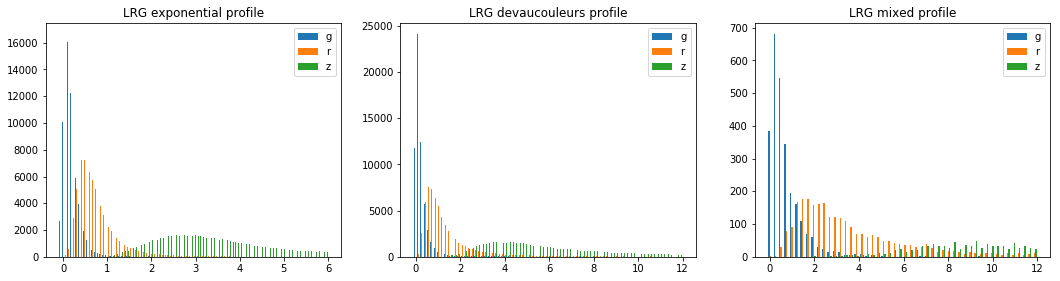

In [17]:
data_exp, err_exp = get_fracdev_cuts(lrg_data, lrg_sig, 'exp', 0.1)
data_dev, err_dev = get_fracdev_cuts(lrg_data, lrg_sig, 'dev', 0.1)
data_mix, err_mix = get_fracdev_cuts(lrg_data, lrg_sig, 'mix', 0.1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 4.3))
ax1.hist((data_exp[0], data_exp[1], data_exp[2]), bins=100, range=(-0.1,6), label=('g', 'r', 'z'))
ax2.hist((data_dev[0], data_dev[1], data_dev[2]), bins=80, range=(-0.1,12), label=('g', 'r', 'z'))
ax3.hist((data_mix[0], data_mix[1], data_mix[2]), bins=50, range=(-0.1,12), label=('g', 'r', 'z'))
ax1.set_title('LRG exponential profile')
ax2.set_title('LRG devaucouleurs profile')
ax3.set_title('LRG mixed profile')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [216]:
# Calculate limiting magnitude for each band
pos_flux = data_exp[2] > 0.001
flux_to_mag(np.min(data_exp[2][pos_flux]))

22.568111147866816

In [260]:
print(data_exp.shape, err_exp.shape)
print(data_dev.shape, err_dev.shape)
print(data_mix.shape, err_mix.shape)

(8, 87540) (8, 87540)
(8, 65135) (8, 65135)
(11, 2828) (11, 2828)


### XD

In [18]:
X_exp, Xerr_exp = XD_format(data_exp, err_exp)
X_dev, Xerr_dev = XD_format(data_dev, err_dev)
X_mix, Xerr_mix = XD_format(data_mix, err_mix)

#print(X_exp.shape, Xerr_exp.shape)
#print(X_dev.shape, Xerr_dev.shape)
#print(X_mix.shape, Xerr_mix.shape)

### Exponential profile


#### Run extreme deconvolution

In [99]:
# Run on 5000 points 
# Takes 40 min to run

start = time.time()
clf = compute_XD_results(X=X_exp[:5000,:], Xerr=Xerr_exp[:5000,:])
end = time.time()
print(end-start)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-pa

2467.254201889038


In [100]:
pickle.dump(clf, open('lrg_xd_exp_5000.p', 'wb'), pickle.HIGHEST_PROTOCOL)
#lrg_clf = pickle.load(open( "lrg_xd_500.p", "rb" ))

#### Sample from extreme deconvolution

In [101]:
lrg_clf = pickle.load(open( "lrg_xd_exp_5000.p", "rb" ))

In [102]:
N = 60000

In [103]:
sample_exp = lrg_clf.sample(N)

XD_exp_sample = np.empty(len(sample_exp), dtype=[('g', 'f4'), ('r', 'f4'), ('z', 'f4'),
                                          ('w1', 'f4'), ('w2', 'f4'), ('exp_r', 'f4'), 
                                           ('exp_e1', 'f4'), ('exp_e2', 'f4')])

for i, name in enumerate(XD_exp_sample.dtype.names):
    XD_exp_sample[name] = sample_exp[:,i] 

### GMM

In [104]:
# Create random number generator for sampling

seed = 123
gen = np.random.RandomState(seed)

#number of components to test for bic
components_range = range(1,100)

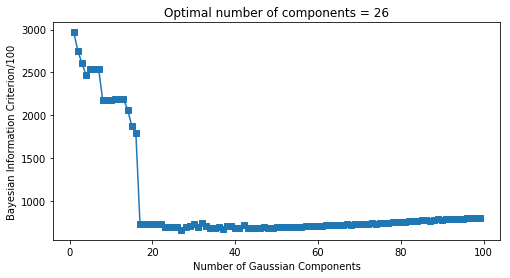

Saved GMM as data/v2/lrg_gmm.fits.


In [105]:
# Compare to GMM

make_gmm_model(X_exp[:5000], components_range, model_filename='data/v2/lrg_gmm.fits', 
               bic_plot=True)

In [106]:
GMM_exp = sample('LRG', n_targets=N, random_state=gen)

```GMM could be giving a different result because this time I'm doing the analysis separately -- with only the exponential component? Before I was making GMMs with all parameters simultaneously...```

#### Add errors back into XD

In [107]:
XD_exp_errs_g = add_xd_errs(XD_exp_sample['g'], err_exp[0])
XD_exp_errs_r = add_xd_errs(XD_exp_sample['r'], err_exp[1])
XD_exp_errs_z = add_xd_errs(XD_exp_sample['z'], err_exp[2])

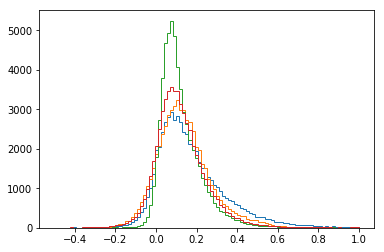

In [615]:
# Not properly normalized

plt.hist(X_exp[:N,0], bins=100, range=(-0.5,1), histtype='step')
plt.hist(GMM_exp[:N,0], bins=100, range=(-0.5,1), histtype='step')
plt.hist(XD_exp_sample['g'], bins=100, range=(-0.5,1), histtype='step')
plt.hist(XD_exp_errs_g, bins=100, range=(-0.5,1), histtype='step')
plt.show()

In [621]:
X_exp[:N,2].shape, GMM_exp[:N,2].shape, XD_exp_errs_z.shape, XD_exp_sample.shape, err_exp.shape[1], len(XD_exp_sample)

((60000,), (60000,), (60000,), (60000,), 87540, 60000)

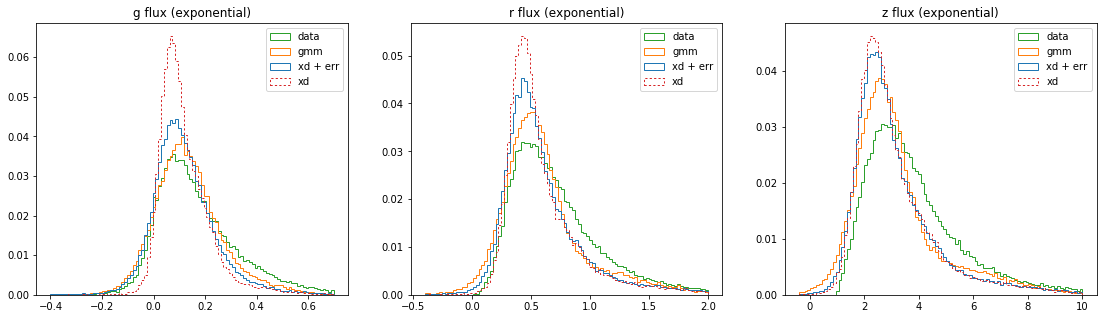

In [108]:
## USE THIS ONE -- normalized
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19, 5))
ax1.hist((XD_exp_errs_g, GMM_exp[:N,0], X_exp[:N,0]), bins=100, range=(-0.4,0.7), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax1.hist(XD_exp_sample['g'], bins=100, range=(-0.4,0.7), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax2.hist((XD_exp_errs_r, GMM_exp[:N,1], X_exp[:N,1]), bins=100, range=(-0.4,2), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax2.hist(XD_exp_sample['r'], bins=100, range=(-0.4,2), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax3.hist((XD_exp_errs_z, GMM_exp[:N,2], X_exp[:N,2]), bins=100, range=(-0.4,10), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax3.hist(XD_exp_sample['z'], bins=100, range=(-0.4,10), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax1.set_title('g flux (exponential)')
ax2.set_title('r flux (exponential)')
ax3.set_title('z flux (exponential)')
ax1.legend()
ax2.legend()
ax3.legend()
#plt.savefig('lrg_exp_norm_hist_60000.png')
plt.show()

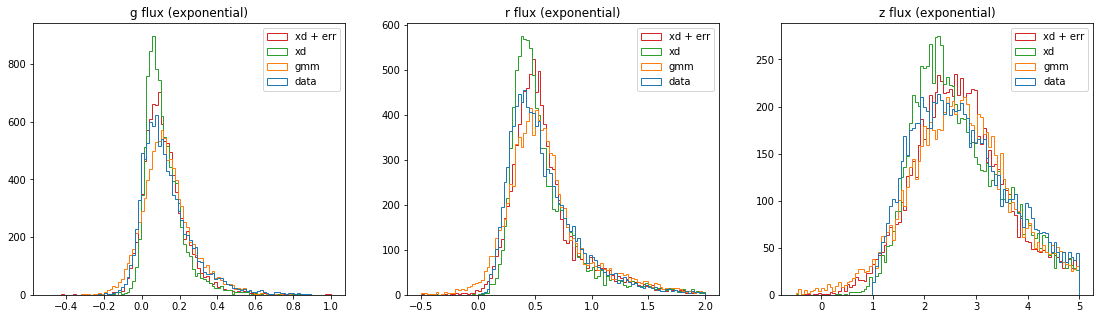

In [249]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19, 5))
ax1.hist((X_exp[:N,0], GMM_exp[:,0], XD_exp_sample['g'], XD_exp_errs_g), bins=100, histtype='step',  range=(-0.5,1), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax2.hist((X_exp[:N,1], GMM_exp[:,1], XD_exp_sample['r'], XD_exp_errs_r), bins=100, histtype='step',  range=(-0.5,2), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax3.hist((X_exp[:N,2], GMM_exp[:,2], XD_exp_sample['z'], XD_exp_errs_z), bins=100, histtype='step',  range=(-0.5,5), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax1.set_title('g flux (exponential)')
ax2.set_title('r flux (exponential)')
ax3.set_title('z flux (exponential)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [310]:
print(chisquare(f_obs=X_exp[:N,0], f_exp=GMM_exp[:,0]))
print(chisquare(f_obs=X_exp[:N,0], f_exp=XD_exp_sample['g']))
print(chisquare(f_obs=X_exp[:N,0], f_exp=XD_exp_errs_g))

Power_divergenceResult(statistic=212108.85173622885, pvalue=0.0)
Power_divergenceResult(statistic=283548.89500027249, pvalue=0.0)
Power_divergenceResult(statistic=549378.2037794299, pvalue=0.0)


### DeVaucouleurs profile

In [21]:
start = time.time()
clf = compute_XD_results(X=X_dev[:5000,:], Xerr=Xerr_dev[:5000,:])
end = time.time()
print(end-start)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-pa

3363.1055829524994


In [93]:
pickle.dump(clf, open('lrg_xd_dev_5000.p', 'wb'), pickle.HIGHEST_PROTOCOL)

In [94]:
lrg_dev_clf = pickle.load(open( "lrg_xd_dev_5000.p", "rb" ))
sample_dev = lrg_dev_clf.sample(N)

XD_dev_sample = np.empty(len(sample_dev), dtype=[('g', 'f4'), ('r', 'f4'), ('z', 'f4'),
                                          ('w1', 'f4'), ('w2', 'f4'), ('exp_r', 'f4'), 
                                           ('exp_e1', 'f4'), ('exp_e2', 'f4')])

for i, name in enumerate(XD_dev_sample.dtype.names):
    XD_dev_sample[name] = sample_dev[:,i] 
    
    
XD_dev_errs = add_xd_errs(XD_dev_sample['g'], err_dev[0])

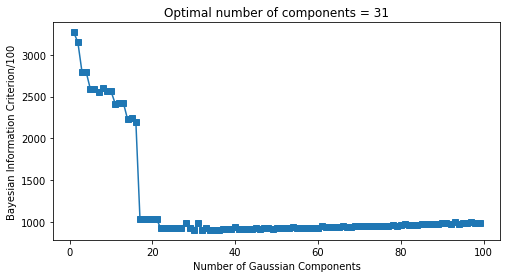

Saved GMM as data/v2/lrg_gmm.fits.


In [95]:
make_gmm_model(X_dev[:5000], components_range, model_filename='data/v2/lrg_gmm.fits', 
               bic_plot=True)

GMM_dev = sample('LRG', n_targets=N, random_state=gen)

In [96]:
XD_dev_errs_g = add_xd_errs(XD_dev_sample['g'], err_dev[0])
XD_dev_errs_r = add_xd_errs(XD_dev_sample['r'], err_dev[1])
XD_dev_errs_z = add_xd_errs(XD_dev_sample['z'], err_dev[2])

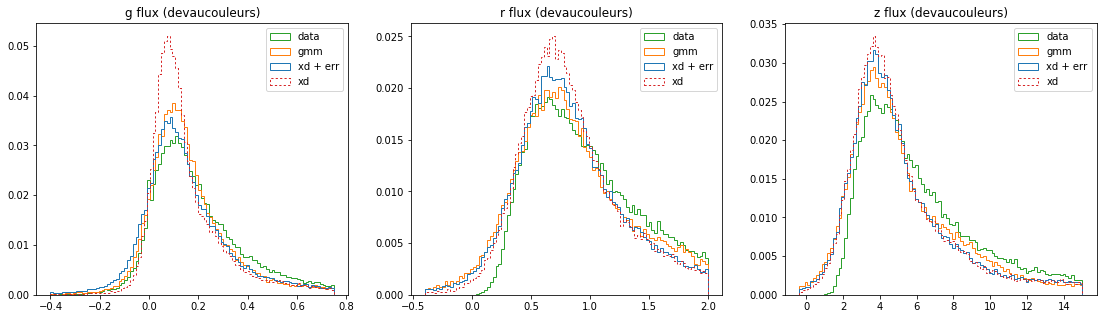

In [97]:
## USE THIS ONE -- normalized
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19, 5))
ax1.hist((XD_dev_errs_g, GMM_dev[:N,0], X_dev[:N,0]), bins=100, range=(-0.4,.75), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax1.hist(XD_dev_sample['g'], bins=100, range=(-0.4,.75), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax2.hist((XD_dev_errs_r, GMM_dev[:N,1], X_dev[:N,1]), bins=100, range=(-0.4,2), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax2.hist(XD_dev_sample['r'], bins=100, range=(-0.4,2), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax3.hist((XD_dev_errs_z, GMM_dev[:N,2], X_dev[:N,2]), bins=100, range=(-0.4,15), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(N)/N), label=('xd + err', 'gmm', 'data'))
ax3.hist(XD_dev_sample['z'], bins=100, range=(-0.4,15), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax1.set_title('g flux (devaucouleurs)')
ax2.set_title('r flux (devaucouleurs)')
ax3.set_title('z flux (devaucouleurs)')
ax1.legend()
ax2.legend()
ax3.legend()
#plt.savefig('lrg_dev_norm_hist_60000.png')
plt.show()

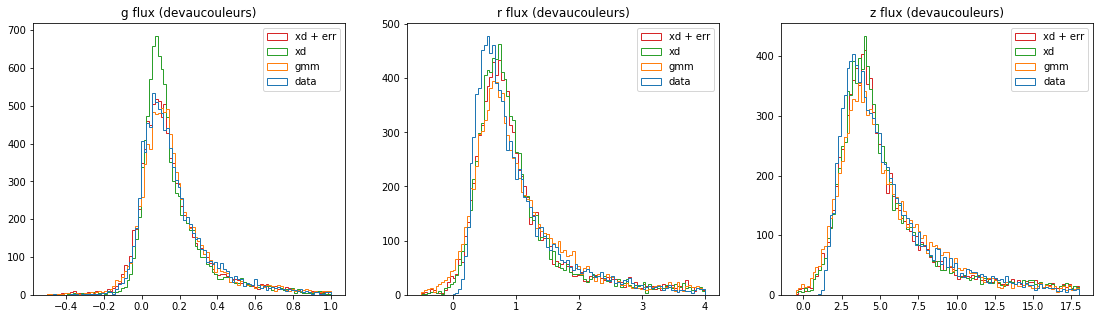

In [303]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19, 5))
ax1.hist((X_dev[:N,0], GMM_dev[:,0], XD_dev_sample['g'], XD_dev_errs_g), bins=100, histtype='step',  range=(-0.5,1), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax2.hist((X_dev[:N,1], GMM_dev[:,1], XD_dev_sample['r'], XD_dev_errs_r), bins=100, histtype='step',  range=(-0.5,4), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax3.hist((X_dev[:N,2], GMM_dev[:,2], XD_dev_sample['z'], XD_dev_errs_z), bins=100, histtype='step',  range=(-0.5,18), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax1.set_title('g flux (devaucouleurs)')
ax2.set_title('r flux (devaucouleurs)')
ax3.set_title('z flux (devaucouleurs)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

### Mixed profiles

```Mix length is 2828```

In [258]:
start = time.time()
clf = compute_XD_results(X=X_mix[:5000,:], Xerr=Xerr_mix[:5000,:])
end = time.time()
print(end-start)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-pa

1537.7370929718018


In [487]:
pickle.dump(clf, open('lrg_xd_mix_2828.p', 'wb'), pickle.HIGHEST_PROTOCOL)

In [488]:
lrg_mix_clf = pickle.load(open( "lrg_xd_mix_2828.p", "rb" ))
sample_mix = lrg_mix_clf.sample(N)

XD_mix_sample = np.empty(len(sample_mix), dtype=[('g', 'f4'), ('r', 'f4'), ('z', 'f4'),
                                          ('w1', 'f4'), ('w2', 'f4'), ('exp_r', 'f4'), 
                                           ('exp_e1', 'f4'), ('exp_e2', 'f4')])

for i, name in enumerate(XD_mix_sample.dtype.names):
    XD_mix_sample[name] = sample_mix[:,i] 
    
    
XD_mix_errs = add_xd_errs(XD_mix_sample['g'], err_mix[0])

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


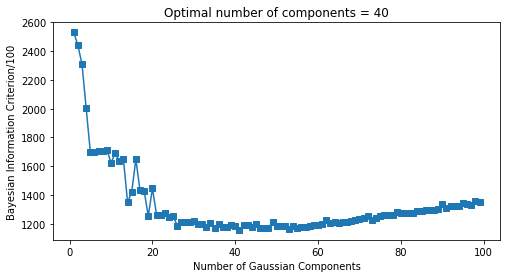

Saved GMM as data/v2/lrg_gmm.fits.


In [489]:
make_gmm_model(X_mix[:5000], components_range, model_filename='data/v2/lrg_gmm.fits', 
               bic_plot=True)

GMM_mix = sample('LRG', n_targets=N, random_state=gen)

In [491]:
XD_mix_errs_g = add_xd_errs(XD_mix_sample['g'], err_mix[0])
XD_mix_errs_r = add_xd_errs(XD_mix_sample['r'], err_mix[1])
XD_mix_errs_z = add_xd_errs(XD_mix_sample['z'], err_mix[2])

In [492]:
n = len(X_mix)

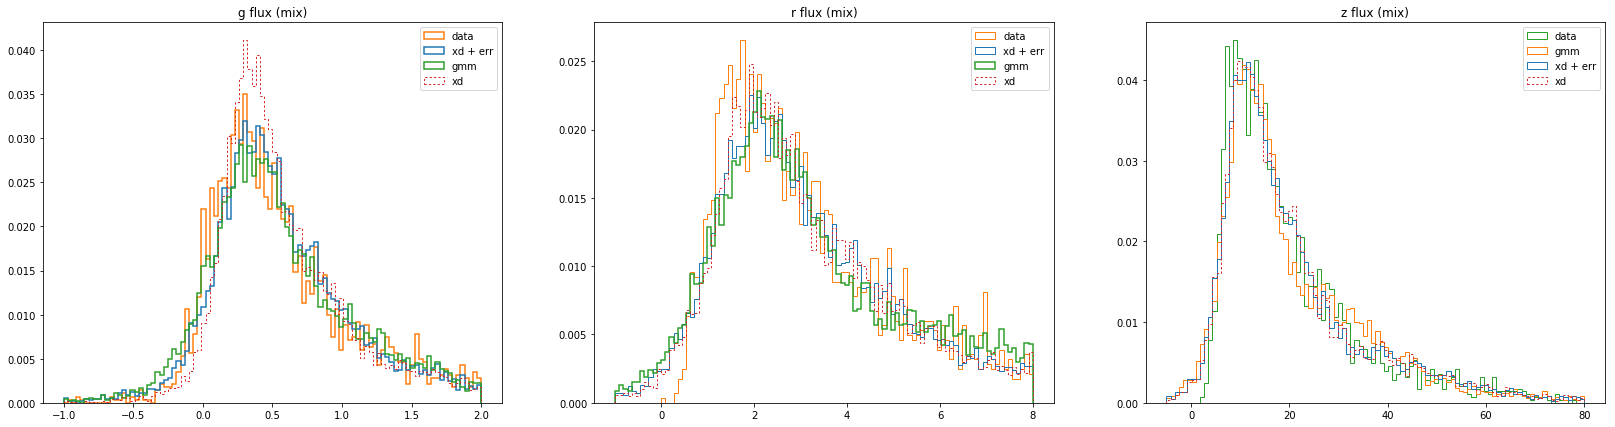

In [536]:
## USE THIS ONE -- normalized
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(28, 7))
ax1.hist((XD_mix_errs_g, X_mix[:n,0]), bins=100, range=(-1,2), histtype='step', 
         weights=(np.ones(N)/N, np.ones(n)/n), label=('xd + err', 'data'), lw=1.5)
ax1.hist(GMM_mix[:N,0],  bins=100, range=(-1,2), histtype='step', weights=np.ones(N)/N, label='gmm', lw=1.5)
ax1.hist(XD_mix_sample['g'], bins=100, range=(-1,2), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax2.hist((XD_mix_errs_r, X_mix[:n,1]), bins=100, range=(-1,8), histtype='step', 
         weights=(np.ones(N)/N, np.ones(n)/n), label=('xd + err', 'data'))
ax2.hist(GMM_mix[:N,1],  bins=100, range=(-1,8), histtype='step', weights=np.ones(N)/N, label='gmm', lw=1.5)
ax2.hist(XD_mix_sample['r'], bins=100, range=(-1,8), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax3.hist((XD_mix_errs_z, GMM_mix[:N,2], X_mix[:n,2]), bins=100, range=(-5,80), histtype='step', 
         weights=(np.ones(N)/N, np.ones(N)/N, np.ones(n)/n), label=('xd + err', 'gmm', 'data'))
ax3.hist(XD_mix_sample['z'], bins=100, range=(-5,80), histtype='step', weights=np.ones(N)/N, label='xd', 
         linestyle='dotted')
ax1.set_title('g flux (mix)')
ax2.set_title('r flux (mix)')
ax3.set_title('z flux (mix)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

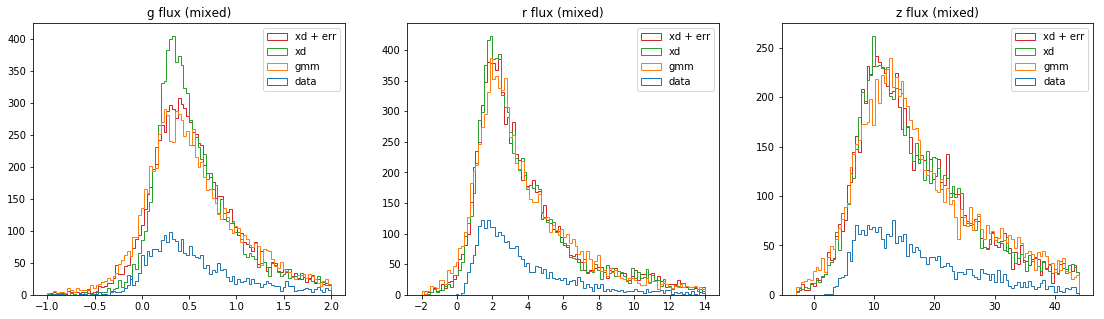

In [299]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19, 5))
ax1.hist((X_mix[:N,0], GMM_mix[:,0], XD_mix_sample['g'], XD_mix_errs_g), bins=100, histtype='step',  range=(-1,2), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax2.hist((X_mix[:N,1], GMM_mix[:,1], XD_mix_sample['r'], XD_mix_errs_r), bins=100, histtype='step',  range=(-2,14), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax3.hist((X_mix[:N,2], GMM_mix[:,2], XD_mix_sample['z'], XD_mix_errs_z), bins=100, histtype='step',  range=(-3,44), 
         label=('data', 'gmm', 'xd', 'xd + err'))
ax1.set_title('g flux (mixed)')
ax2.set_title('r flux (mixed)')
ax3.set_title('z flux (mixed)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()